## MNIST

it has 70000 small images of digits handwritten by high school students and employees of the US Census Bureau.

In [1]:
import sys
assert sys.version_info >= (3,5)
import sklearn
assert sklearn.__version__ >= '0.20'
import numpy as np
import os

In [2]:
np.random.seed(42)

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

In [4]:
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'Classification'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok= True)

def save_fig(fig_id, tight_layout = True, fig_extension = 'png', resolution = 300):
    path = os.path.join(IMAGE_PATH, fig_id+'.'+ fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

In [5]:
from sklearn.datasets import fetch_openml

In [14]:
mnist= fetch_openml('mnist_784', version=1, as_frame=False)
# gives Pandas DF by default. To avoid this as_frame= False

In [15]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by sklearn generally have a similar dictionary structure.

In [16]:
# lets look at these arrays
X,y = mnist['data'], mnist['target']

In [17]:
X.shape

(70000, 784)

In [18]:
y.shape

(70000,)

There are 70000 images and each image has 784 features. This is because each image is 28 x 28 pixels. Each feature simply represents one pixel's  intensity, from 0 (white) to 255(black). 

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [20]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

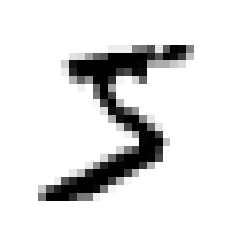

In [22]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [23]:
# label
y[0]

'5'

In [24]:
# type casting labels from string to int
y =  y.astype(np.uint8)

In [25]:
# spliting the data into train and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

## Training Binary Classifier

5-detector a binary classifier, diatinguising between two classes.

In [26]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Lets start with a Stochastic Gradient Decent (SGD) classifier.

Thid classifier has the advantage of being capable of handling very large datasets efficiently. This is because SGD deals with training instances independently, one at a time (which makes SGD well suited for online learning), 

In [27]:
from sklearn.linear_model import SGDClassifier

In [28]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [29]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

#### Measuring accuracy using Cross Validation

Use cross_val_score() function to evaluate our SGDClassifier model, using k-fold cross-validation with three folds.

In [30]:
from sklearn.model_selection import cross_val_score

In [31]:
cross_val_score(sgd_clf,X_train,y_train_5, cv=3, scoring='accuracy')

array([0.9612 , 0.95095, 0.9621 ])

In [32]:
from sklearn.base import BaseEstimator

In [33]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [34]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That's right this dumb classifier has 90% accuracy. This is simply because only about 10% of the images are 5s, so if you always guess image as not a 5, you will be right about 90% of the time.

This demonstrated why accuracy is not the preferred performance measure for the classifier, especially when you are dealing with skewed datasets.

### Confusion Matrix

The general idea is to count the number of times the instances of class A are classified as class B. For example, to know the number of times the classifier confused image of 5s with 3s.

In [35]:
from sklearn.model_selection import cross_val_predict

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross_validation, but insted of returning the evaluation scores, it returns the predictions made on each test fold.

In [50]:
# confusion matrix()
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix(y_train_5, y_train_pred)

array([[54148,   431],
       [ 1603,  3818]], dtype=int64)

Each row represents the actual class, and each column represents predicted class. 

first row ==> non 5s ( Negative class)

second row ==> 5s (positive class)

first row first column ==> True Negative ( correctly classified as non 5s)

second row second column ==> True Positve (correctly classified as 5s)

first row second column ==> False Positive (wrongly classified as 5s)

second row first column ==> False Negative (wrongly classified as non 5s)

Perfect classifier would have true positive and true negative

In [39]:
y_train_perfect_prediction = y_train_5
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Accuracy of the positive predictions ==> Precision 

Ratio of positive instances that are correctly detected by the classifiers ==> recall or sensitivity or true positive rate

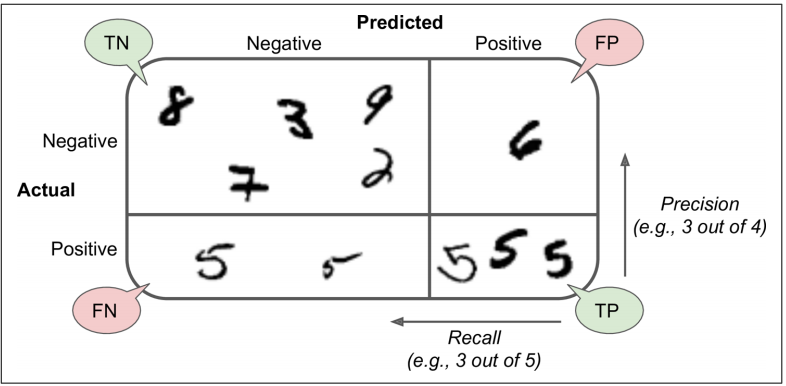


## Precision and Recall

In [40]:
from sklearn.metrics import precision_score, recall_score

In [42]:
precision_score(y_train_5, y_train_pred)

0.8985643680866087

In [43]:
recall_score(y_train_5, y_train_pred)

0.7042980999815532

In [44]:
from sklearn.metrics import f1_score

In [45]:
f1_score(y_train_5, y_train_pred)

0.7896587383660806

F1 score favors classifier that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. 

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called precision/recall trade-off.

**How the SGDClassifier makes its classification?**

For each instsnce, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class, otherwise it assignes it to the negative class.

decision_function() method returns a score for each instance, and then uses any threshold you want to make predictons based on those scores.

In [46]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

In [48]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred
# the SGDClassifier uses a threshold equal to 0

array([ True])

In [62]:
threshold = 2165
y_some_digit_pred = (y_score  > threshold)
y_some_digit_pred

array([False])

This confirms the raising the threshold decreases recall. 

How do you decide which threshold to use?

Use the cross_val_predict() function to get the score of all instances in the training set, but this time specify that you want to return decision scores insted of predictions.

with these scores, use the precision_recall_curve() function to compute precision and recall for all possible threshold.

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = 'decision_function')

In [52]:
from sklearn.metrics import precision_recall_curve

In [53]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


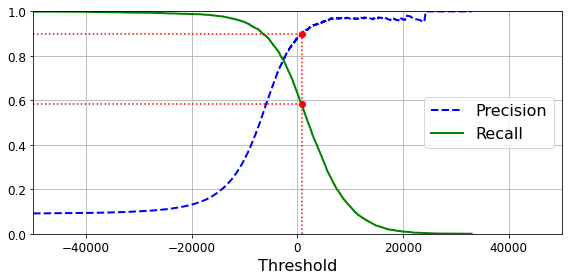

In [54]:
# plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                             
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

In [55]:
(y_train_pred == (y_scores > 0)).all()

False

Saving figure precision_vs_recall_plot


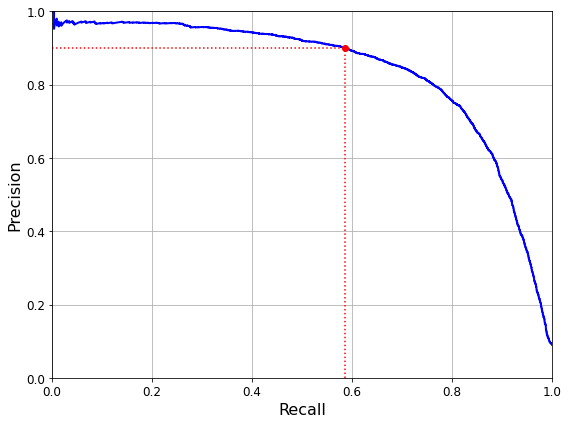

In [56]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

for 90% precision, looking at the first plot, need threshold of about 2200. 

To find lowest threshold that gives atleast 90% precision 

np.argmax() will give you the first index of the maximum value, which in this case means the first True value

In [64]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

781.4253240110138

In [65]:
# to make predictions, insted of calling classifier's predict() method
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [66]:
# the above predictors' precision and recall
precision_score(y_train_5, y_train_pred_90)

0.9001135073779796

In [67]:
recall_score(y_train_5, y_train_pred_90)

0.5851318944844125

You can fairly create a classifier with virtually any precision you want.

But high precision classifier is not very useful if its recall is too low.

## The ROC Curve

The Receiver Operating Characteristics (ROC) is similar to the precision/recall curve, but insted of plotting precision vs recall, the ROC curve plots the true positive rate(recall) against false positive rate(FPR --> Ratio of negative instanses falsly classified as positive). 

FPR = 1 - true negative rate(TNR --> Ratio of negative instanses that are correctly classified as negative)

TNR is also called specificity.

Hence, the ROC curve plots sensitivity(recall) vs 1 - specificity

In [68]:
# compute tpr and fpr for various threshold values
from sklearn.metrics import roc_curve

In [70]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

Saving figure roc_curve_plot


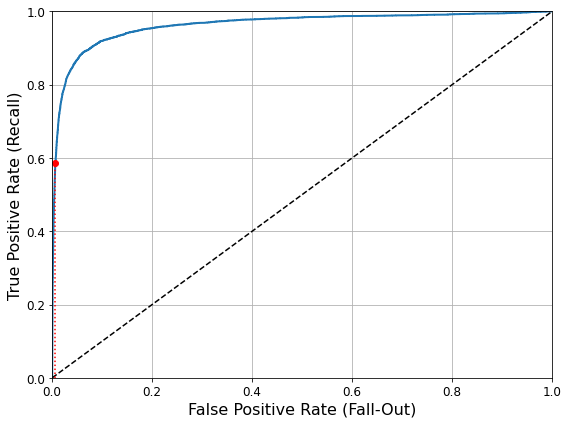

In [71]:
# plot fpr against tpr
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

There is a trade-off: higher the recall (TRP), the more false positive (FPR) the classifier produces. 

The dotted line represents the ROC curve of a purely random classifier, a good classifier stays as far away from the line as possible, towards top- left corner.

One way to compare classifiers is to measure the area under the curve(AUC). A perfect classifier would have AUC==1, where purely random classifier will have 0.5

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9631113184029219

Which curve to choose, ROC or PR?

Prefer PR curve whenever positive class is rare or when you care more about false positives than the false negatives.

Other wise use ROC.

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).

**Lets now train RandomForestClassifier and compare its ROC curve and ROC AUC score**

RandomForestClassifier does not have a decision_function() method. insted has a predict_proba() method which returns an array containing a row per instance and a column per class, each containing the probability that the given instanse belong to the given class.

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
forest_clf = RandomForestClassifier(random_state=42)

In [75]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method = 'predict_proba')

In [76]:
# roc_curve() function expects labels and scores
# but insted, give it class probabilities
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholes_forest = roc_curve(y_train_5, 
                                                      y_scores_forest)

Saving figure roc_curve_comparison_plot


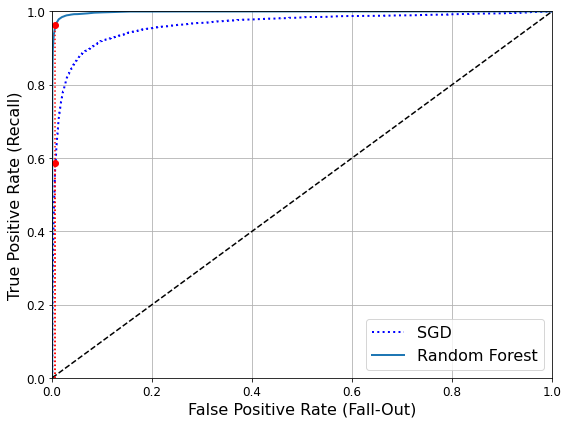

In [77]:
# plot ROC curve
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

RandomForestClassifier's ROC curve looks much better than the SGDClassifier's. 

In [78]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984174599189782

In [79]:
# measuring precision and recall
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9900676246830094

In [80]:
recall_score(y_train_5, y_train_pred_forest)

0.864231691569821

# Multiclass Classification

Distinguishing among more then two classes.

SGDClassifiers, RandomForestClassifier and naive Bayes classifier are capable of handling multipleclasses 

Logistic Regression or Support Vector Machine classifiers are strictly binary classifiers. However you can use to perform multiclass classificaion with multiple binary classifiers.

Different types of multiclass classifiers:

1. One-verses-the rest(OvR) strategy: Create 10 binary classifiers( 0-detector, 1-detector,...). Get the decision score from every classifier for the image and select he highest score. For most binary classification algorithms, OvR is preferred.

2. One-verses-One (OvO): Train a binary classifier for every pair ( 0s and 1s, 0s and 2s, 0s and 3s,...). If there are N classes, you need to train N x (N - 1) / 2 classifiers. for MNIST problem 45 classifiers needs to be trained and see which class wins the most duels. SVM classifier scales poorly with the size of the training set, hence OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. 

Sklearn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm.



In [81]:
# lets try with a SVM classifier
from sklearn.svm import SVC

In [84]:
svm_clf = SVC()

In [85]:
svm_clf.fit(X_train, y_train) # not y_train_5

SVC()

In [88]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [89]:
svm_clf.predict([X_train[2]])

array([4], dtype=uint8)

In [90]:
y_train[2]

4

SVC is trained on original target classs from 0 to 9, insted of the 5-vs-the rest. Under the hood, SKlearn actually used the OvO strategy: it trained 45 classifiers, got theit decision scores for the image, and select the class that won the most duels.

In [93]:
# decision_function() returns 10 scores per  instance
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [94]:
# highest score
np.argmax(some_digit_scores)

5

In [95]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [96]:
svm_clf.classes_[5]

5

If you want to force the sklearn to use OvO or OvR, you may use OneVsOneClassifier or OneVsRestClassifier classes. 

In [97]:
from sklearn.multiclass import OneVsRestClassifier

In [99]:
ovr_clf = OneVsRestClassifier(SVC())

In [100]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [102]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [103]:
len(ovr_clf.estimators_)

10

In [104]:
# training an SGDClassifier
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [105]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time  sklearn did not have to run OvR or OvO because SGDClassifiers can directly classify instances into multiple classes. 

In [107]:
# decision_function()
sgd_clf.decision_function([some_digit])

array([[-21981.13003572, -30256.84920311,  -9442.96811535,
          2978.45677623, -22144.14789545,    153.40256543,
        -30557.9693124 , -13218.90264708,  -8327.55154424,
         -7832.92719249]])

Classifier is fairly confident about its prediction. Almost all scores are largely negative, class 5 has a score of ---. Model has slight doubt regarding class 3 (score -->  ).

Use cross-validation-score function to evaluate the SGDClassifier's accuracy

In [108]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8412 , 0.84595, 0.89215])

If you used  a random classifier, you would get 10% accuracy. 

Simply scaling the inputs increases accuracy above 89%.

In [109]:
from sklearn.preprocessing import StandardScaler

In [110]:
scaler = StandardScaler()

In [111]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [112]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

C:\Users\saivi\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.90235, 0.8949 , 0.90525])

# Error Analysis

Follow the steps in your ML project checklist. 

Assume that you have found a promissing model and you want to find ways to improve it.

Analyze the type of errors it makes.

In [113]:
# Make predictions using the cross_val_predict() function.
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [114]:
# now create the confusion marix
conf_mx = confusion_matrix(y_train, y_train_pred)

In [115]:
conf_mx

array([[5577,    0,   23,    6,    9,   45,   36,    6,  220,    1],
       [   0, 6399,   38,   23,    4,   44,    4,    7,  213,   10],
       [  27,   26, 5252,   91,   71,   28,   65,   39,  351,    8],
       [  22,   18,  121, 5225,    2,  212,   27,   39,  393,   72],
       [  12,   14,   47,   10, 5207,   12,   35,   25,  320,  160],
       [  28,   15,   33,  169,   54, 4451,   75,   16,  523,   57],
       [  29,   15,   44,    2,   43,   98, 5553,    4,  129,    1],
       [  20,    9,   52,   27,   51,   13,    3, 5704,  183,  203],
       [  17,   65,   49,   90,    3,  128,   25,   10, 5421,   43],
       [  24,   18,   30,   65,  115,   33,    1,  182,  374, 5107]],
      dtype=int64)

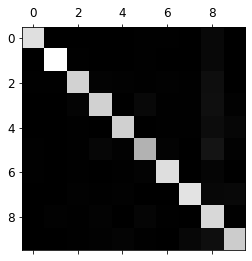

In [116]:
# image representation of confusion matrix
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. 

5s look slightly dimmer, which could mean that there are fewer images of 5s in the dataset or the classifier does not perform well on 5s as on other digits. 

Lets focus the plot on the errors. 

In [117]:
# divide each value in the confusion matrix by the number of images in 
# the corresponding class, to compute error rate insted of abs number of error
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [118]:
norm_conf_mx = conf_mx / row_sums

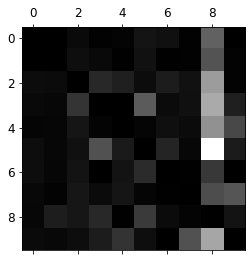

In [119]:
# plot the results
# fill the diagonals with 0
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Row represents the actual class and the column represents the predicted class. The column for the class 8 is quite bright, many images are classified as 8s. However the row of 8s is not that bad, actual 8s are classified as 8s. even 5s and 3s are confuses in both directios.

Analysing confusion matrix often gives you insights into ways to improve your classifier. Looking at the plot, it seems that the effort should be spent on reducing false 8s. gather more training data the looks like 8s or engineer new feature that would help the classifier. 

example: writing an algo to count number of closes loops. or'

preprocess the images(using sklearn,OpenCV, Pillow) to make some patterns, such as closed loops, stand out more.

# Multilabel Classification

Until now we worked on just one class. In some cases you want your classifier to output multiple classes for each instance. 

Consider a face recognision classifier: what should it do if recognizes several people in the same picture? It should attach one tag per person it recogniaes. If a classifier has been trained to recognize 3 faces,A,B,C. Then when a classifier is shown a picture of A and C, the output should be[0,1,0]

In [120]:
# KNN supports multilabel classification, though not all classifiers do
from sklearn.neighbors import KNeighborsClassifier

In [121]:
# create 2 target labels for each digit image
y_train_large = (y_train >= 7) # whether or not the digit is large (7,8,9)
y_train_odd = (y_train % 2 == 1)# whether or not it is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

In [122]:
knn_clf = KNeighborsClassifier() 

In [124]:
knn_clf.fit(X_train, y_multilabel) # train using multiple target array

KNeighborsClassifier()

In [125]:
knn_clf.predict([some_digit])
#digit 5 is indeed not large and it is odd

array([[False,  True]])

In [126]:
# compute f1 score
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)

In [127]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605